In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from scipy import stats

***1. Chargement des données***

In [2]:
df = pd.read_csv('Telco-Churn.csv')

**------------ -------------**

***2. Analyse Exploratoire des données (EDA)***

**2.1. Overview**

In [3]:
print(df.info()) #Types des données et compter les valeurs non-nulles

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
print(df.describe()) #Afficher les tendances centrales de colomnes numériques

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


**2.2. Distirbution des Classes**

In [5]:
print("---- CHURN DISTRIBUTION ------")
print(df['Churn'].value_counts(normalize=True) * 100)

---- CHURN DISTRIBUTION ------
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


*2.2.1. Diagramme Circulaire de la distribution des classes*

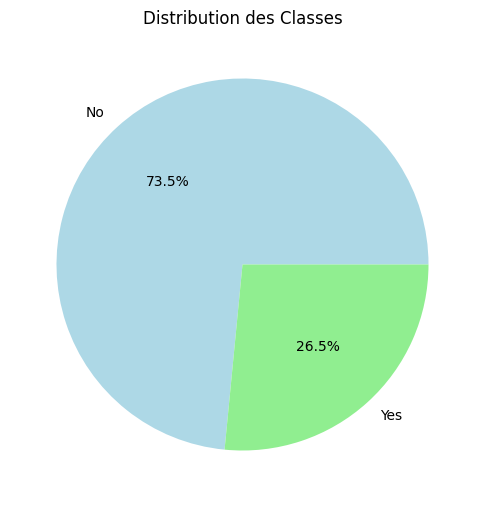

In [6]:
plt.figure(figsize=(6,7))
df['Churn'].value_counts().plot.pie(labels=['No' ,'Yes'],colors=['lightblue' ,'lightgreen'] ,autopct='%1.1f%%')
plt.title('Distribution des Classes')
plt.ylabel('')
plt.show()

**2.3. Visualisation des variables**

*2.3.1. Variables numériques*

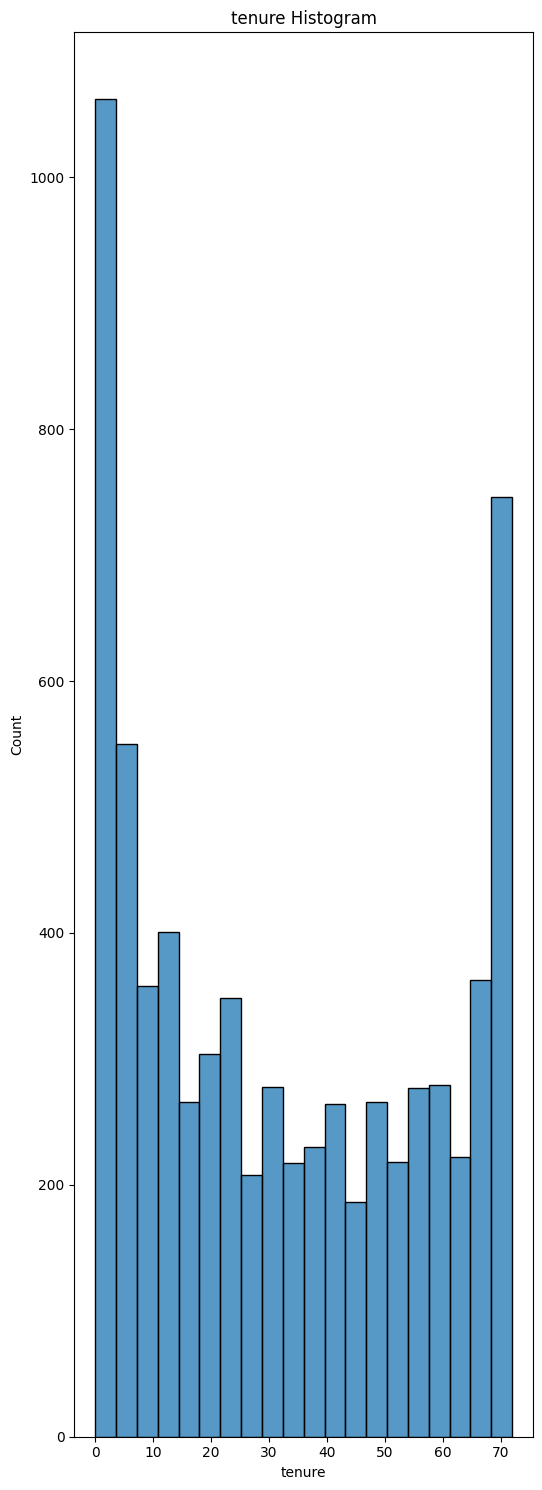

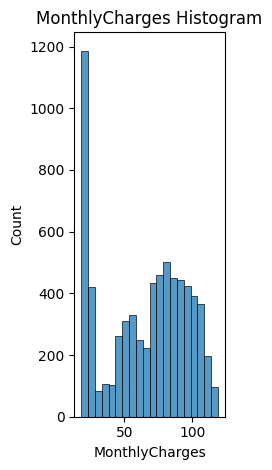

In [50]:
num_vars = ['tenure' ,'MonthlyCharges']
plt.figure(figsize=(15 ,15))
for i ,col in enumerate(num_vars ,1):
    plt.subplot(1 ,3 ,i)
    sns.histplot(df[col] ,bins=20)
    plt.title(f'{col} Histogram')
    plt.tight_layout()
    plt.show()

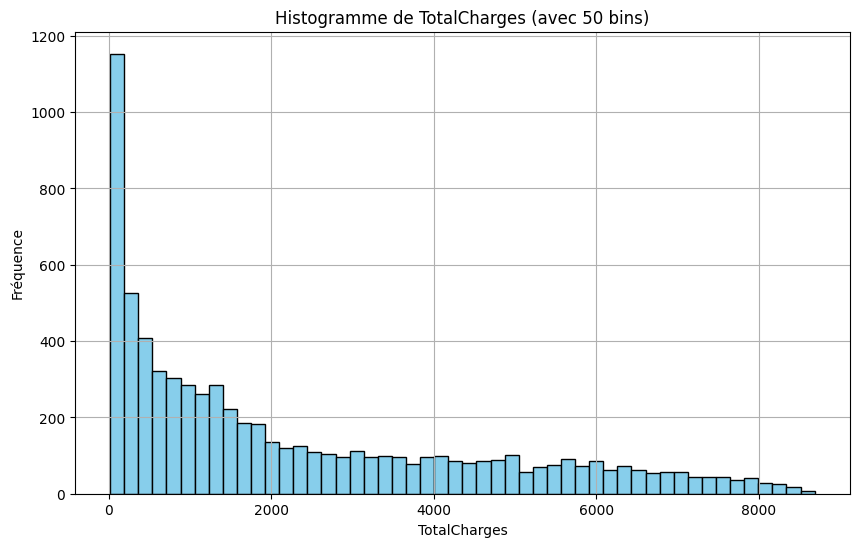

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') 
df = df.dropna(subset=['TotalCharges']) 

plt.figure(figsize=(10, 6))
plt.hist(df['TotalCharges'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogramme de TotalCharges (avec 50 bins)')
plt.xlabel('TotalCharges')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

*2.3.2. Variables categorielles*

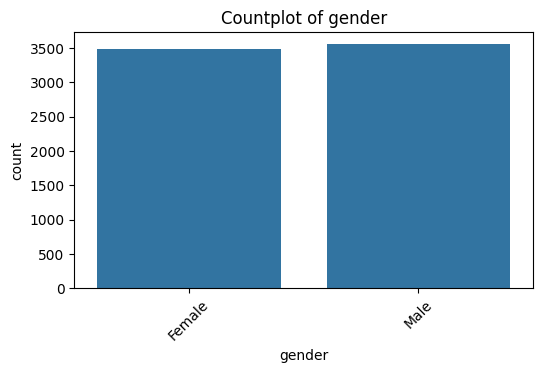

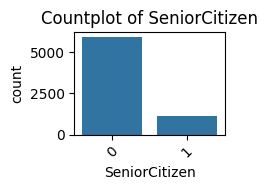

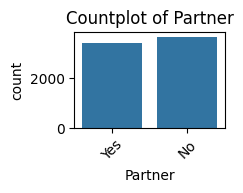

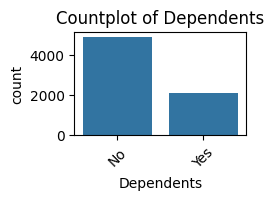

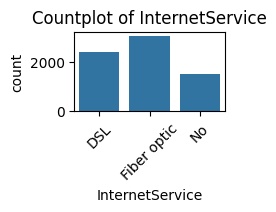

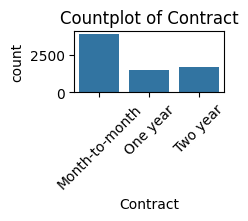

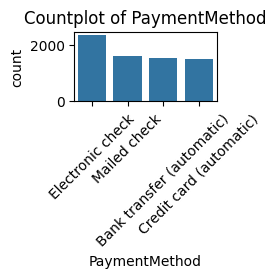

In [8]:
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'Contract', 'PaymentMethod']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3 ,3 ,i)
    sns.countplot(x=col, data=df)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**2.4. Analyse des facteurs influencant le Churn**

*2.4.1. Influence des variables numériques sur le Churn*

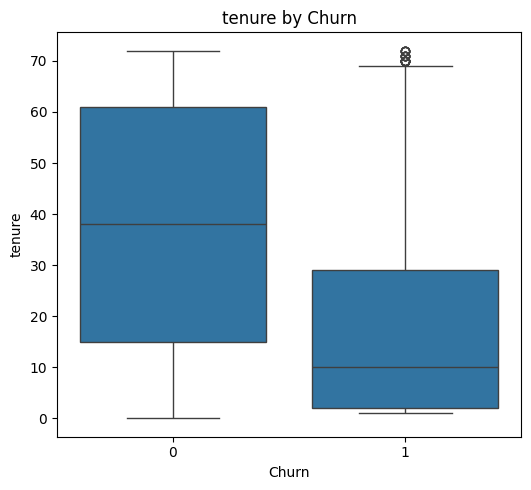

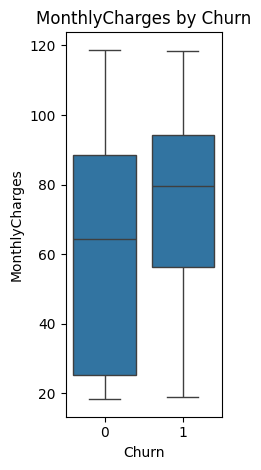

In [52]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(num_vars, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} by Churn')
    plt.tight_layout()
    plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_2296\3676566129.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='TotalCharges', data=df, palette='Set2', showfliers=True)


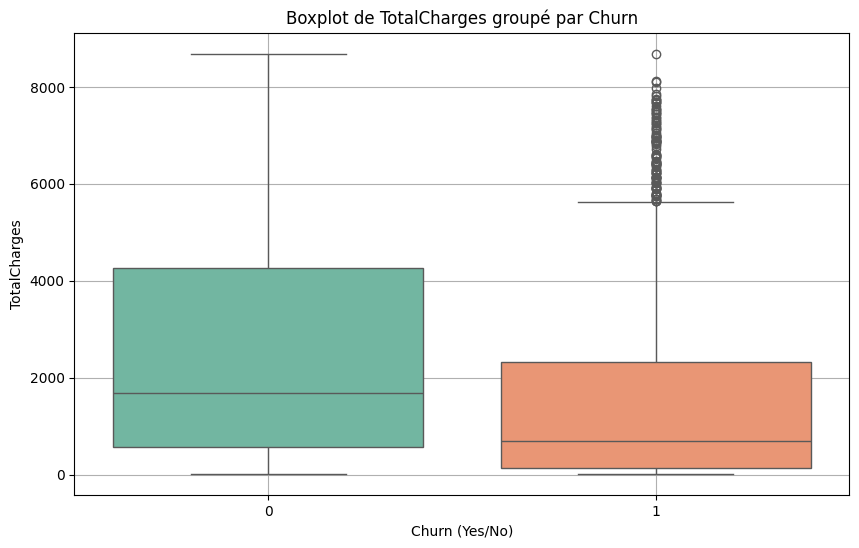

In [53]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convertir en float
df = df.dropna(subset=['TotalCharges'])  # Supprimer NaN

# Option 1 : Boxplot basique amélioré (avec groupement par Churn pour plus de sens)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=df, palette='Set2', showfliers=True)
plt.title('Boxplot de TotalCharges groupé par Churn')
plt.xlabel('Churn (Yes/No)')
plt.ylabel('TotalCharges')
plt.grid(True)
plt.show()

*2.4.2. Influence des variables cartégorielles sur le Churn*

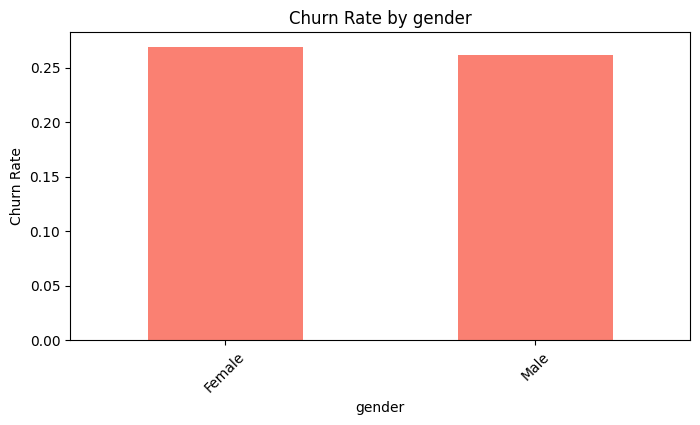

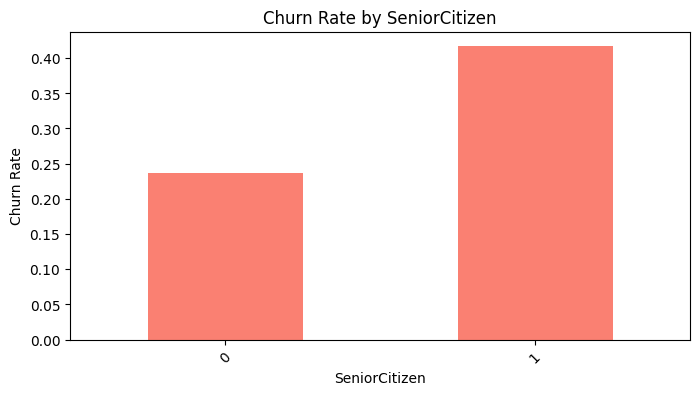

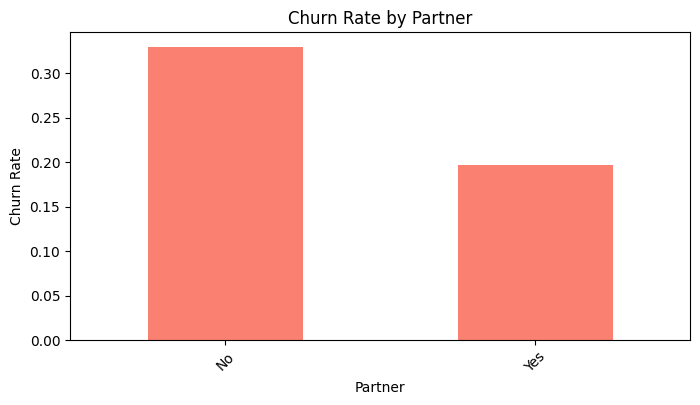

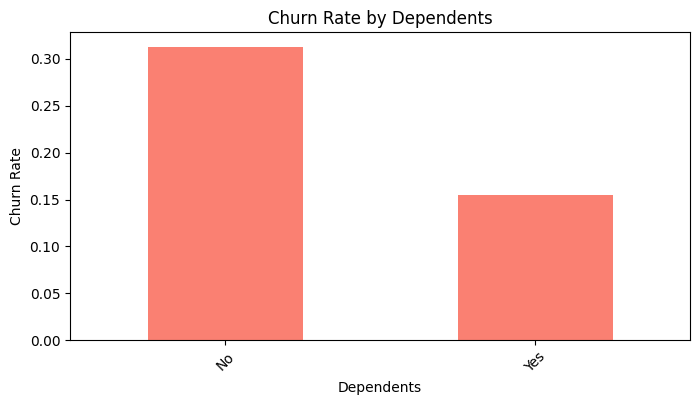

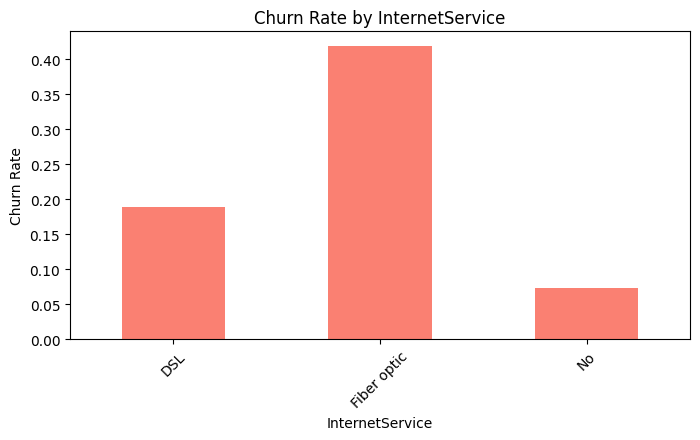

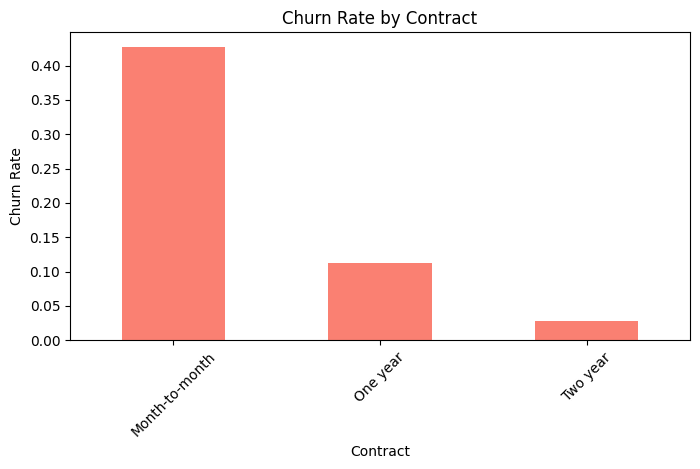

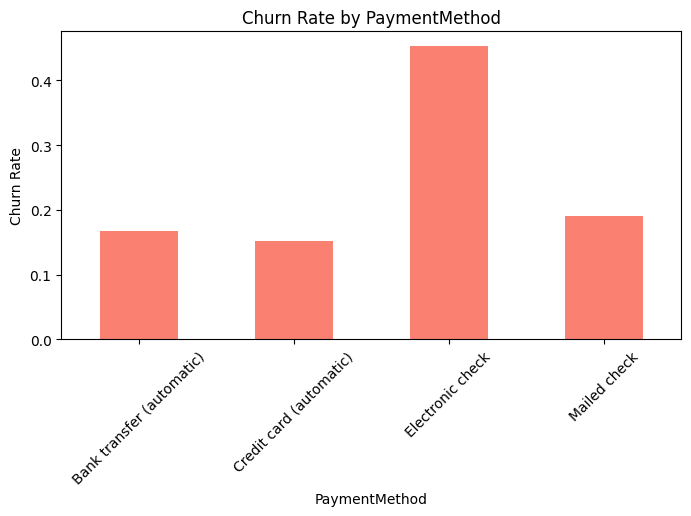

In [10]:
for col in categorical_cols:
    churn_rate = df.groupby(col)['Churn'].value_counts(normalize=True).unstack().fillna(0)['Yes']
    plt.figure(figsize=(8, 4))
    churn_rate.plot(kind='bar', color='salmon')
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Churn Rate')
    plt.xticks(rotation=45)
    plt.show()

**------------ -------------**

***3. Prétraitement des données***

**3.1. Nettoyage des données**

*3.1.1. Suppression de la colonne 'customer ID'*

In [11]:
df = df.drop(['customerID'], axis=1)

In [12]:
print("Nombre de valeurs manquantes par colonne:\n", df.isnull().sum())

Nombre de valeurs manquantes par colonne:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


⚠️ Aucune des colonnes contient des valeurs manquantes, MAIS les valeurs manquantes sont affichées en type int64 et pourtant des colonnes tel que 'TotalCharges' utilisent des strings et peuvent contenir des strings vides ' '⚠️

In [13]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [14]:
print("Nombre de valeurs manquantes par colonne:\n", df.isnull().sum())

Nombre de valeurs manquantes par colonne:
 gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


❌ La colonne 'TotalCharges' contient 11 NaNs

In [15]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [16]:
print("Valeurs manquantes aprés nettoyage:\n", df.isnull().sum())

Valeurs manquantes aprés nettoyage:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


✅ Et voila le travail !

**3.2. Normalisation et Scaling**

In [17]:
X = df.drop('Churn', axis=1)
y = df['Churn']
scaler = StandardScaler()
X[num_vars] = scaler.fit_transform(X[num_vars])

**3.3. Encodage**

*3.3.1 Encodage des valeurs categorielles en numériques binaires*

In [18]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
                'PaperlessBilling', 'Churn']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

*3.3.1 Encodage des valeurs categorielles multi-classes en numériques (OneHotEncoder)*

In [19]:
multi_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection','TechSupport',
               'StreamingTV', 'StreamingMovies', 'Contract', 
                              'PaymentMethod']
df = pd.get_dummies(df, columns=multi_cols, drop_first=True)  

In [20]:
print("Données après encodage:\n", df.head())

Données après encodage:
    gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...   
3                 0           42.30       1840.75      0  ...   
4                 1           70.70        151.65      1  ...   

   TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0            False                            False            False   
1            

In [21]:
print("Types des données après encodage:\n", df.dtypes)
print()
print("Dimensions des données après encodage:", df.shape)

Types des données après encodage:
 gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes              

**3.4. PCA**

In [22]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df.drop('Churn', axis=1))

In [23]:
print("Nombre de composantes PCA:", pca.n_components_)
print("Ratio de variance expliquée par chaque composante:", pca.explained_variance_ratio_)

Nombre de composantes PCA: 1
Ratio de variance expliquée par chaque composante: [0.99986001]


**3.5. Divsion du Dataset (Training /Test)**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
print("Taille du jeu d'entraînement:", X_train.shape)
print("Taille du jeu de test:", X_test.shape)

Taille du jeu d'entraînement: (5634, 1)
Taille du jeu de test: (1409, 1)


**------------ -------------**

***4. Validation Croisée***

In [25]:
models = {
    'KNN': KNeighborsClassifier(),  
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    print(f"---- {name} ----")

---- KNN ----
---- Naive Bayes ----
---- Decision Tree ----
---- Random Forest ----


**4.1. Validation Croisée avec k=5**

In [26]:
cv5_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"CV = 5 Scores: {cv5_scores}")
print(f"CV5 Mean Accuracy: {cv5_scores.mean():.4f}")

CV = 5 Scores: [0.63886424 0.63442768 0.63708962 0.65394854 0.65452931]
CV5 Mean Accuracy: 0.6438


**4.2. Validation Croisée avec k=10**

In [27]:
cv10_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
print(f"CV = 10 Scores: {cv10_scores}")
print(f"CV10 Mean Accuracy: {cv10_scores.mean():.4f}")

CV = 10 Scores: [0.64716312 0.63297872 0.64007092 0.63120567 0.63765542 0.62877442
 0.6749556  0.63943162 0.64831261 0.63410302]
CV10 Mean Accuracy: 0.6415


**------------ -------------**

***5. Application des algorithmes de Machine Learning***

In [28]:
import time

models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),  
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

predictions = {}
trained_models = {}

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    trained_models[name] = model
    predictions[name] = y_pred

    acc = accuracy_score(y_test ,y_pred)
    print(f"{name}: Accuracy = {acc:.2f}, Training Time = {train_time:.4f} seconds")

K-Nearest Neighbors: Accuracy = 0.73, Training Time = 0.0200 seconds
Naive Bayes: Accuracy = 0.73, Training Time = 0.0256 seconds
Decision Tree: Accuracy = 0.64, Training Time = 0.0563 seconds
Random Forest: Accuracy = 0.65, Training Time = 1.8524 seconds


**------------ -------------**

***6. Evaluation des Performances***

In [29]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score','AUC'])

In [30]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

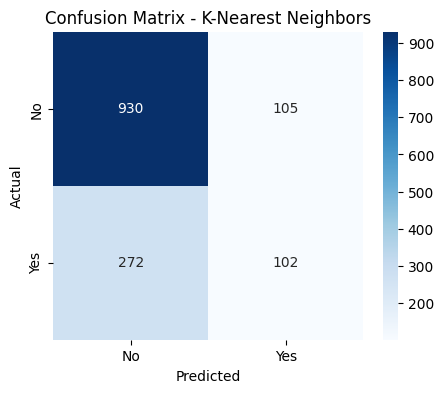

C:\Users\PC\AppData\Local\Temp\ipykernel_2296\1812396950.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Model': [name], 'Accuracy': [acc], 'Precision': [prec], 'Recall': [rec], 'F1-Score': [f1], 'AUC': [auc]})], ignore_index=True)
c:\Users\PC\OneDrive\Desktop\DAMI_Project\dami-proj\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


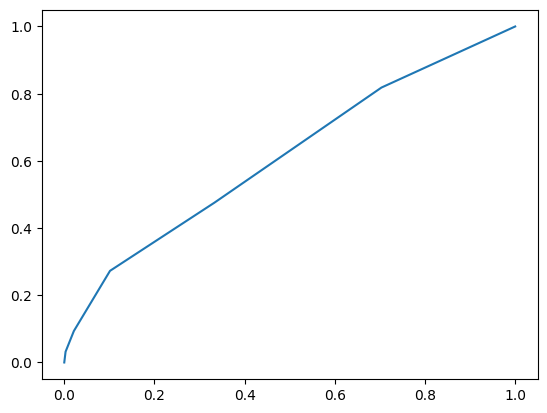

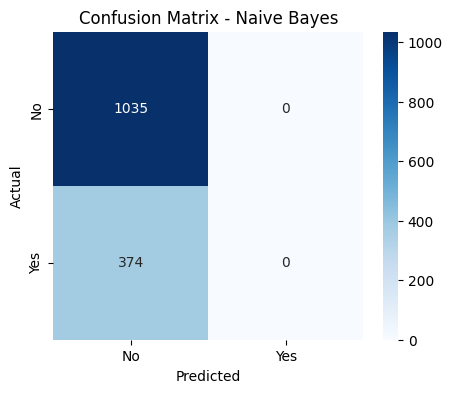

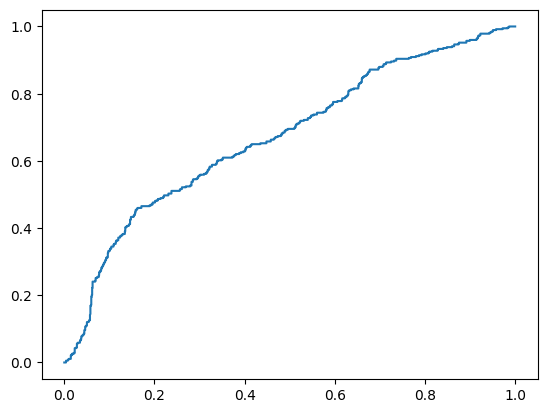

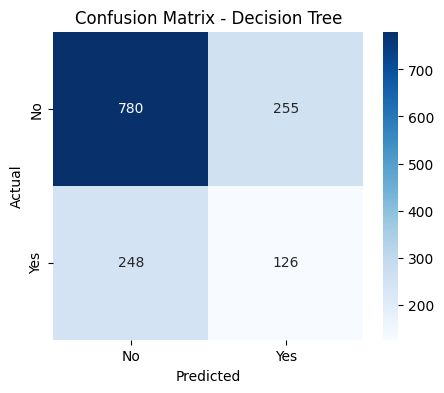

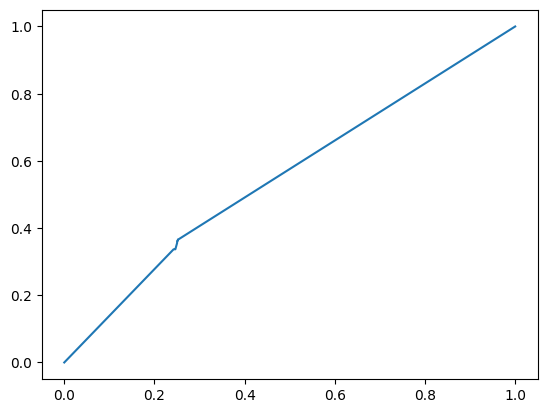

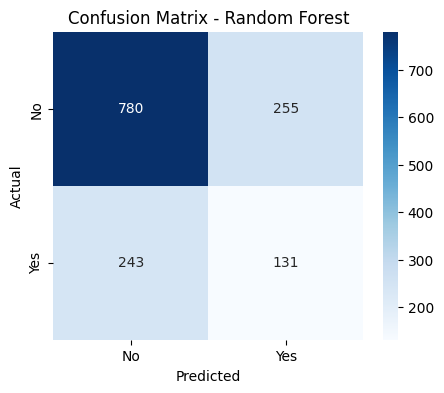

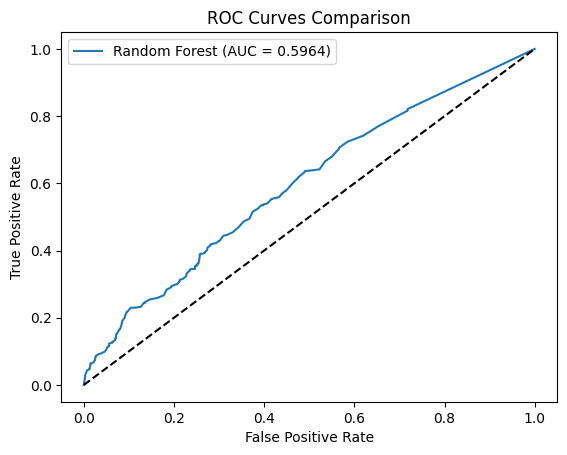

In [31]:
for name, y_pred in predictions.items():
    # Metrics (with pos_label='Yes')
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label='Yes')
    rec = recall_score(y_test, y_pred, pos_label='Yes')
    f1 = f1_score(y_test, y_pred, pos_label='Yes')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve and AUC (binarize y_test and y_prob)
    model = trained_models[name]
    if hasattr(model, 'predict_proba'):  # NB, DT, RF have probs; KNN does too
        y_prob = model.predict_proba(X_test)[:, 1] if name != 'NB' else model.predict_proba(X_test)[:, model.classes_.tolist().index('Yes')]
        y_test_bin = (y_test == 'Yes').astype(int)  # 'Yes' → 1, 'No' → 0
        fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
        auc = roc_auc_score(y_test_bin, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    else:
        auc = np.nan  # Fallback if no probs
    
    # Store results
    results = pd.concat([results, pd.DataFrame({'Model': [name], 'Accuracy': [acc], 'Precision': [prec], 'Recall': [rec], 'F1-Score': [f1], 'AUC': [auc]})], ignore_index=True)

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Random line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

In [32]:
print("Model Performance Summary:\n", results)
results.to_csv('base_model.csv' ,index=False)

Model Performance Summary:
                  Model  Accuracy  Precision    Recall  F1-Score       AUC
0  K-Nearest Neighbors  0.732434   0.492754  0.272727  0.351119  0.611785
1          Naive Bayes  0.734564   0.000000  0.000000  0.000000  0.671756
2        Decision Tree  0.643009   0.330709  0.336898  0.333775  0.554766
3        Random Forest  0.646558   0.339378  0.350267  0.344737  0.596412


**------------ -------------**

***7. Optimisation des hyperparamétres avec GridSearch***

**7.1. Définition des paramétres**

In [33]:
param_grids = {
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    },
    'Decision Tree': {
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}

In [34]:
tuned_models = {}
tuned_predictions = {}
tuned_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])

plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>


Tuning K-Nearest Neighbors...


c:\Users\PC\OneDrive\Desktop\DAMI_Project\dami-proj\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best Params: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}


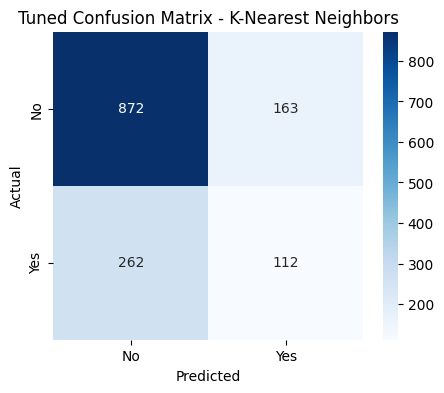

C:\Users\PC\AppData\Local\Temp\ipykernel_2296\4061173257.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tuned_results = pd.concat([tuned_results, pd.DataFrame({'Model': [name], 'Accuracy': [acc], 'Precision': [prec], 'Recall': [rec], 'F1-Score': [f1], 'AUC': [auc]})], ignore_index=True)


Tuning Time: 12.9461s

Tuning Naive Bayes...


c:\Users\PC\OneDrive\Desktop\DAMI_Project\dami-proj\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(
c:\Users\PC\OneDrive\Desktop\DAMI_Project\dami-proj\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Best Params: {'var_smoothing': 1e-09}


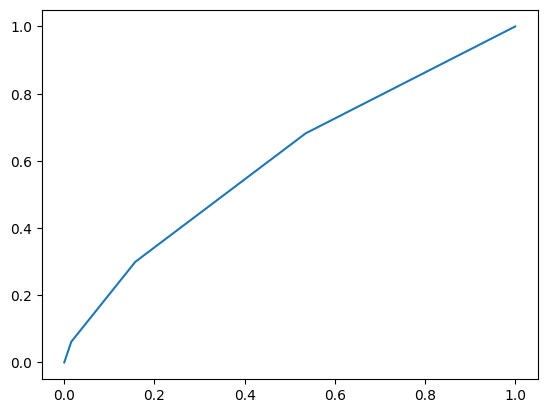

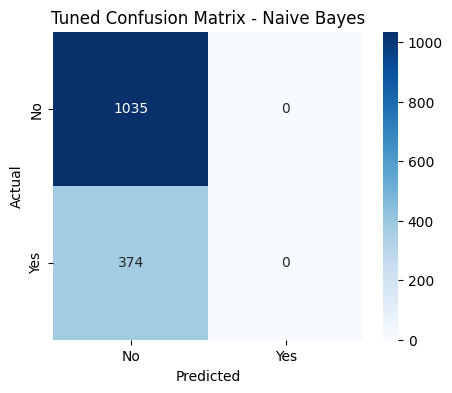

Tuning Time: 0.2982s

Tuning Decision Tree...


c:\Users\PC\OneDrive\Desktop\DAMI_Project\dami-proj\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


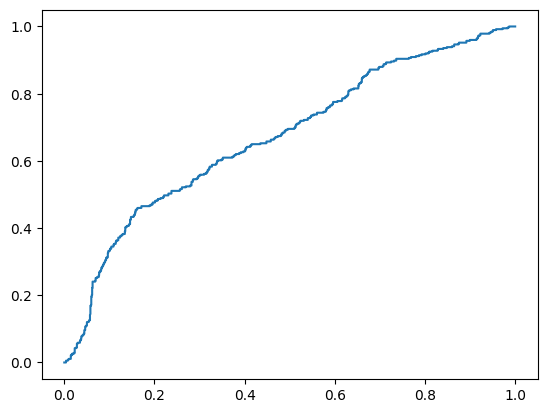

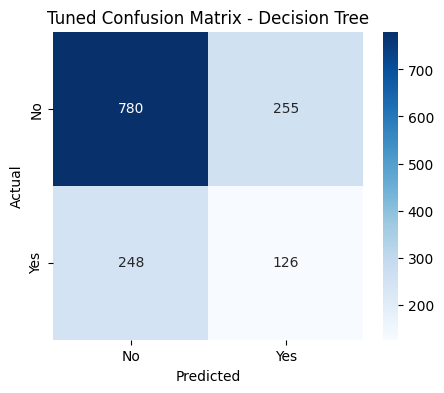

Tuning Time: 2.0265s

Tuning Random Forest...


c:\Users\PC\OneDrive\Desktop\DAMI_Project\dami-proj\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


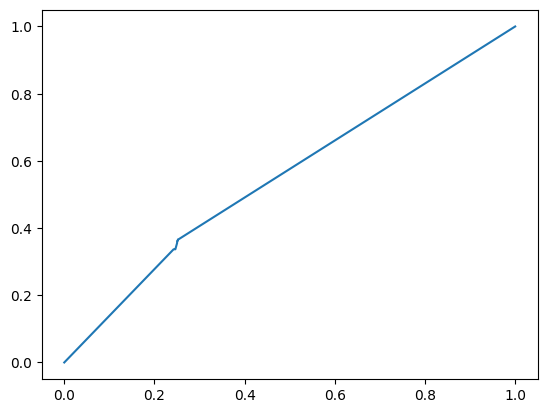

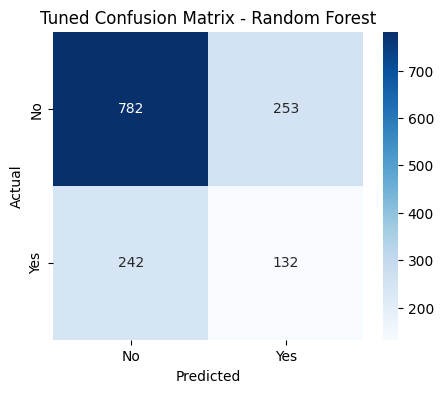

Tuning Time: 87.7369s


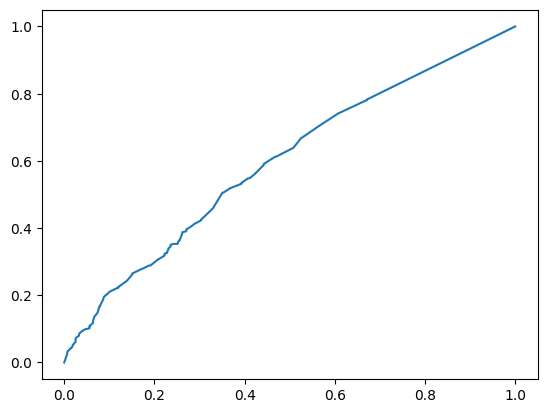

In [35]:
for name in models.keys():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(estimator=models[name], param_grid=param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    start_time = time.time()
    grid.fit(X_train, y_train)
    tune_time = time.time() - start_time
    
    # Best params and model
    print(f"Best Params: {grid.best_params_}")
    best_model = grid.best_estimator_
    tuned_models[name] = best_model
    
    # Predict on test
    y_pred = best_model.predict(X_test)
    tuned_predictions[name] = y_pred
    
    # Metrics (using string labels)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label='Yes')
    rec = recall_score(y_test, y_pred, pos_label='Yes')
    f1 = f1_score(y_test, y_pred, pos_label='Yes')
    
    # Confusion Matrix (optional, can comment out if too many plots)
    cm = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Tuned Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC and AUC
    if hasattr(best_model, 'predict_proba'):
        y_prob = best_model.predict_proba(X_test)[:, 1] if name != 'Naive Bayes' else best_model.predict_proba(X_test)[:, list(best_model.classes_).index('Yes')]
        y_test_bin = (y_test == 'Yes').astype(int)
        fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
        auc = roc_auc_score(y_test_bin, y_prob)
        plt.plot(fpr, tpr, label=f'Tuned {name} (AUC = {auc:.4f})')
    else:
        auc = np.nan
    
    # Store
    tuned_results = pd.concat([tuned_results, pd.DataFrame({'Model': [name], 'Accuracy': [acc], 'Precision': [prec], 'Recall': [rec], 'F1-Score': [f1], 'AUC': [auc]})], ignore_index=True)
    
    print(f"Tuning Time: {tune_time:.4f}s")

C:\Users\PC\AppData\Local\Temp\ipykernel_2296\2370034149.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


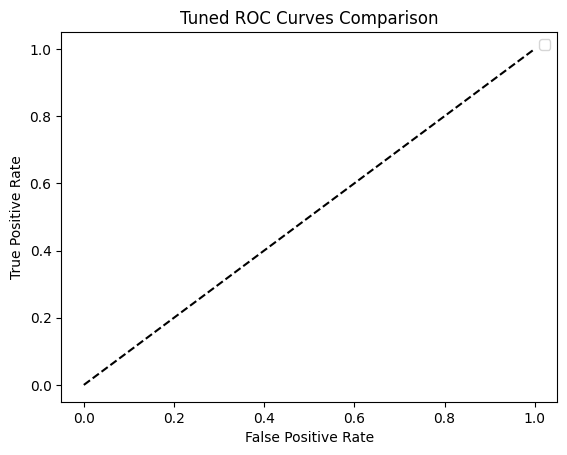


Baseline vs Tuned Comparison:
                      Accuracy_Baseline  Precision_Baseline  Recall_Baseline  \
Model                                                                         
K-Nearest Neighbors           0.732434            0.492754         0.272727   
Naive Bayes                   0.734564            0.000000         0.000000   
Decision Tree                 0.643009            0.330709         0.336898   
Random Forest                 0.646558            0.339378         0.350267   

                     F1-Score_Baseline  AUC_Baseline  Accuracy_Tuned  \
Model                                                                  
K-Nearest Neighbors           0.351119      0.611785        0.698368   
Naive Bayes                   0.000000      0.671756        0.734564   
Decision Tree                 0.333775      0.554766        0.643009   
Random Forest                 0.344737      0.596412        0.648687   

                     Precision_Tuned  Recall_Tuned  F1-Score

In [36]:
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned ROC Curves Comparison')
plt.legend()
plt.show()

# Compare baseline vs tuned (assuming 'results' from Step 6)
comparison = pd.merge(results.set_index('Model'), tuned_results.set_index('Model'), left_index=True, right_index=True, suffixes=('_Baseline', '_Tuned'))
print("\nBaseline vs Tuned Comparison:\n", comparison)

# Save tuned results
tuned_results.to_csv('tuned_results.csv', index=False)
comparison.to_csv('comparison_baseline_tuned.csv')

**------------ -------------**

***8. Application des différentes techniques de réequilibrage***

In [37]:
rebalancers = {
    'SMOTE': SMOTE(random_state=42),
    'Oversampling': RandomOverSampler(random_state=42),
    'Undersampling': RandomUnderSampler(random_state=42)
}

In [45]:
resampled_data = {}

for rb_name, rebalancer in rebalancers.items():
    print(f"==== APPLICATION DU {rb_name} ====")
    start_time = time.time()
    X_res, y_res = rebalancer.fit_resample(X_train, y_train)
    res_time = time.time() - start_time
    
    resampled_data[rb_name] = (X_res, y_res)
    
    # Check balance
    print(f"Resampled shapes: X {X_res.shape}, y distribution:\n{y_res.value_counts(normalize=True) * 100}")
    print(f"Resampling Time: {res_time:.4f}s")
    print(f"==== FIN DU {rb_name} ====")
    print()

==== APPLICATION DU SMOTE ====
Resampled shapes: X (8278, 1), y distribution:
Churn
No     50.0
Yes    50.0
Name: proportion, dtype: float64
Resampling Time: 0.0317s
==== FIN DU SMOTE ====

==== APPLICATION DU Oversampling ====
Resampled shapes: X (8278, 1), y distribution:
Churn
No     50.0
Yes    50.0
Name: proportion, dtype: float64
Resampling Time: 0.0243s
==== FIN DU Oversampling ====

==== APPLICATION DU Undersampling ====
Resampled shapes: X (2990, 1), y distribution:
Churn
No     50.0
Yes    50.0
Name: proportion, dtype: float64
Resampling Time: 0.0195s
==== FIN DU Undersampling ====



**------------ -------------**

***9. Ré-calculation des performances*** 

In [46]:
rebalanced_results = pd.DataFrame(columns=['Rebalancer', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])

<Figure size 1200x800 with 0 Axes>

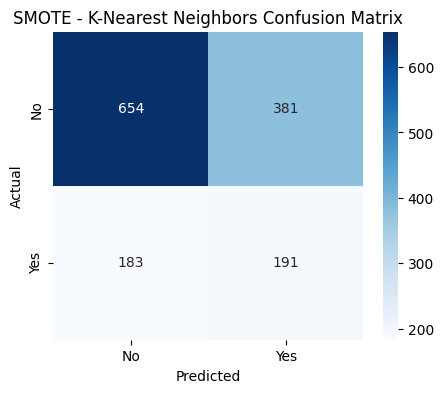

C:\Users\PC\AppData\Local\Temp\ipykernel_2296\3701343579.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rebalanced_results = pd.concat([rebalanced_results, pd.DataFrame({'Rebalancer': [rb_name], 'Model': [model_name], 'Accuracy': [acc], 'Precision': [prec], 'Recall': [rec], 'F1-Score': [f1], 'AUC': [auc]})], ignore_index=True)


SMOTE + K-Nearest Neighbors: Accuracy = 0.5997, Training Time = 0.0229s


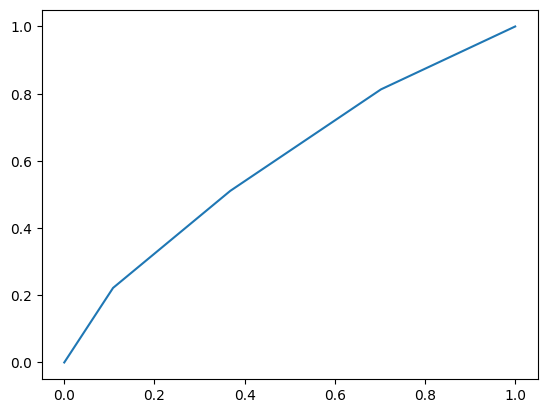

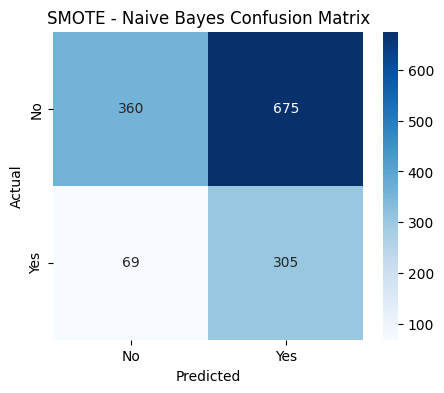

SMOTE + Naive Bayes: Accuracy = 0.4720, Training Time = 0.0340s


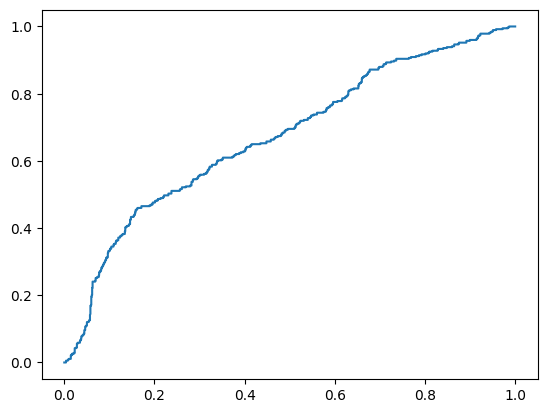

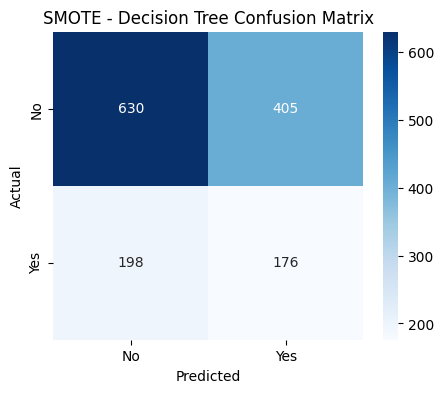

SMOTE + Decision Tree: Accuracy = 0.5720, Training Time = 0.0523s


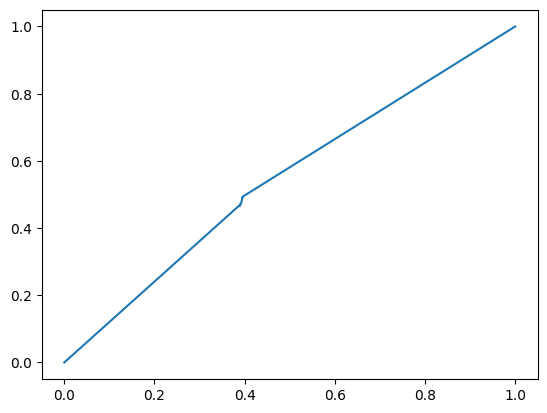

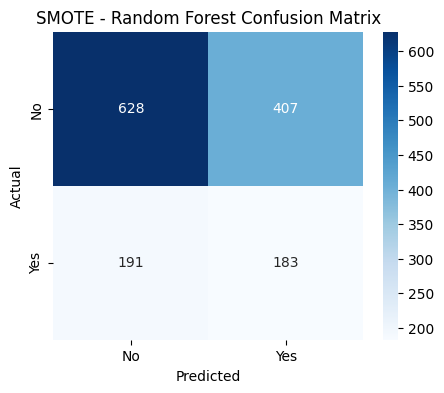

SMOTE + Random Forest: Accuracy = 0.5756, Training Time = 1.0929s


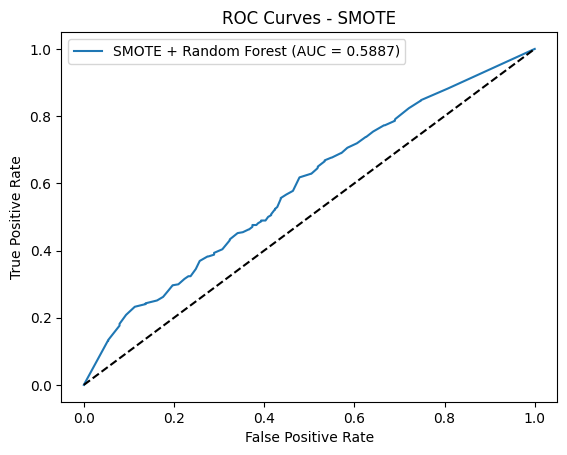

<Figure size 1200x800 with 0 Axes>

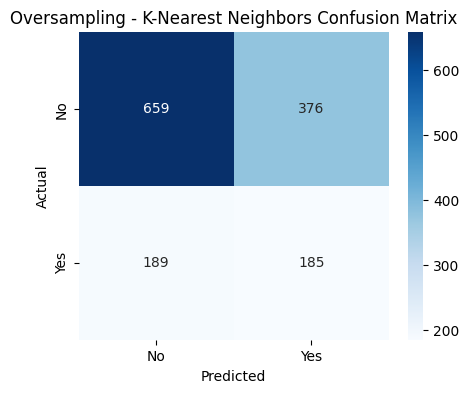

Oversampling + K-Nearest Neighbors: Accuracy = 0.5990, Training Time = 0.0127s


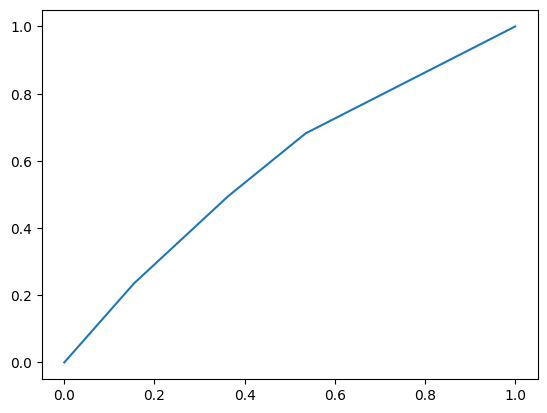

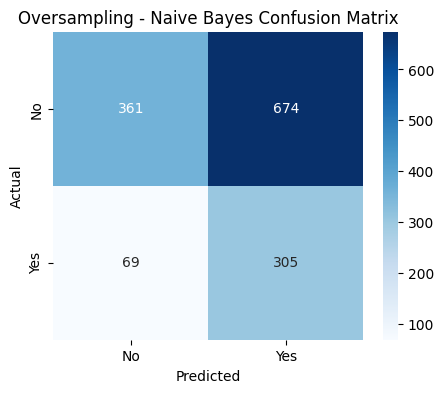

Oversampling + Naive Bayes: Accuracy = 0.4727, Training Time = 0.0190s


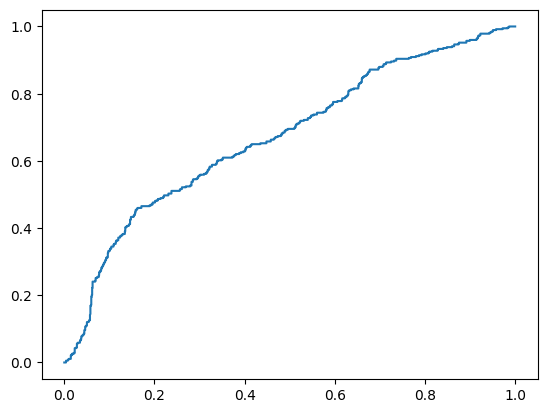

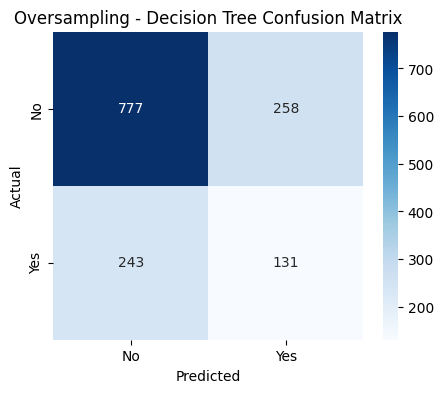

Oversampling + Decision Tree: Accuracy = 0.6444, Training Time = 0.0528s


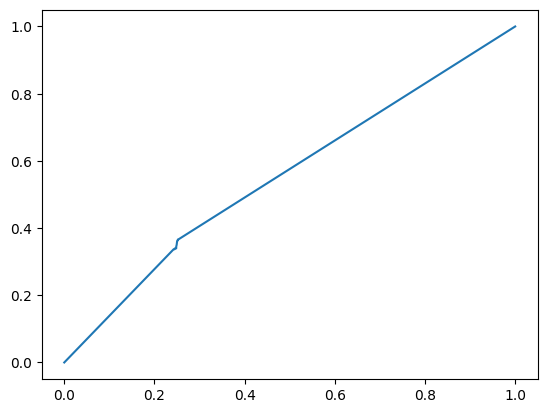

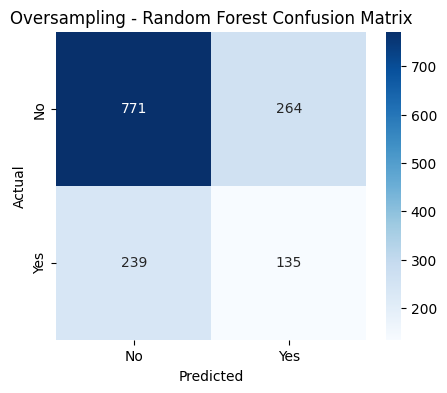

Oversampling + Random Forest: Accuracy = 0.6430, Training Time = 1.1295s


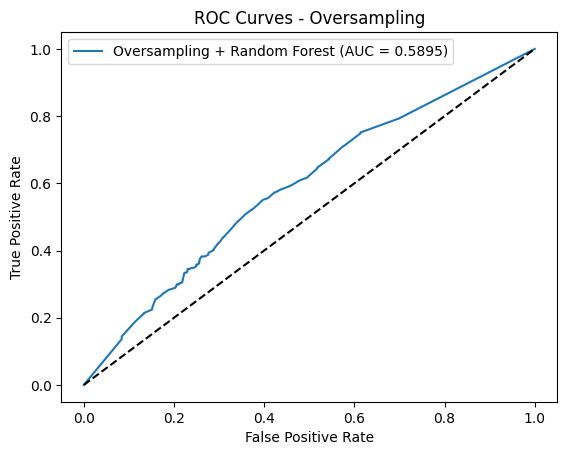

<Figure size 1200x800 with 0 Axes>

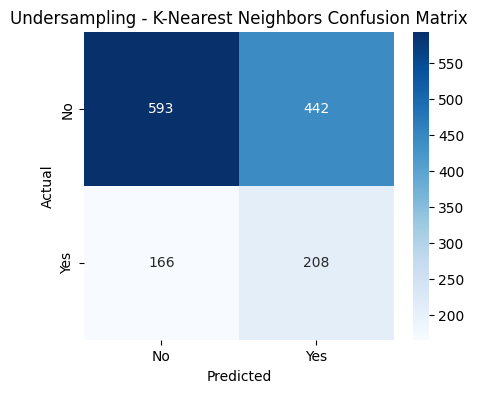

Undersampling + K-Nearest Neighbors: Accuracy = 0.5685, Training Time = 0.0059s


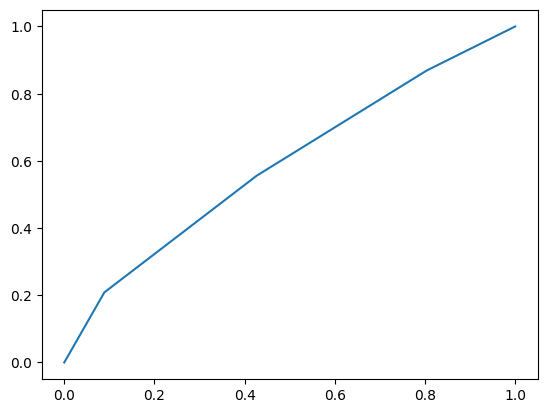

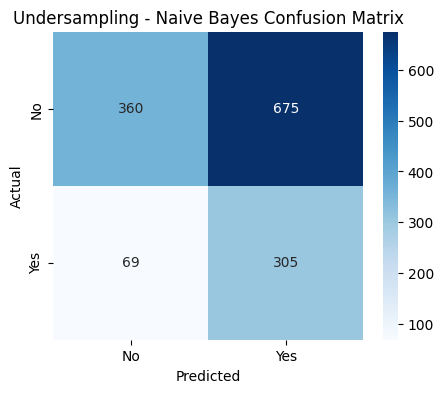

Undersampling + Naive Bayes: Accuracy = 0.4720, Training Time = 0.0076s


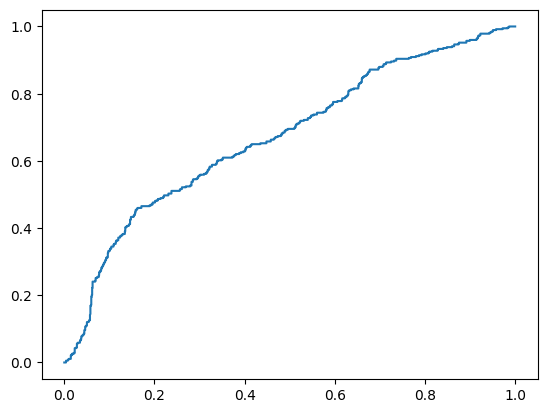

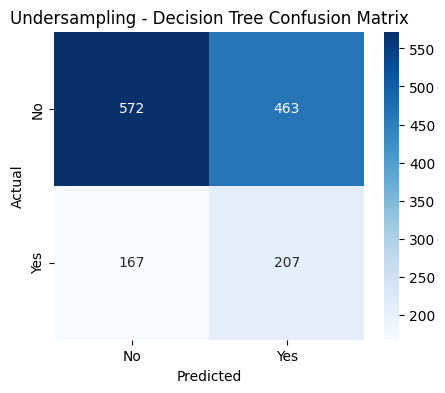

Undersampling + Decision Tree: Accuracy = 0.5529, Training Time = 0.0751s


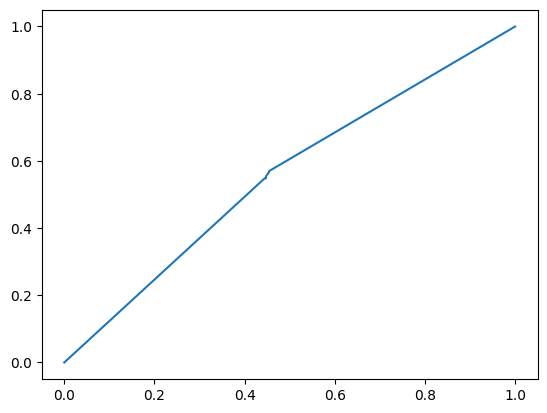

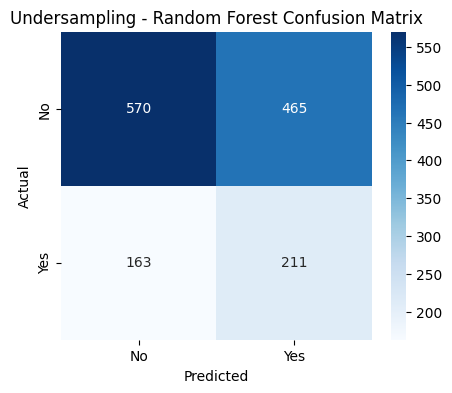

Undersampling + Random Forest: Accuracy = 0.5543, Training Time = 0.4144s


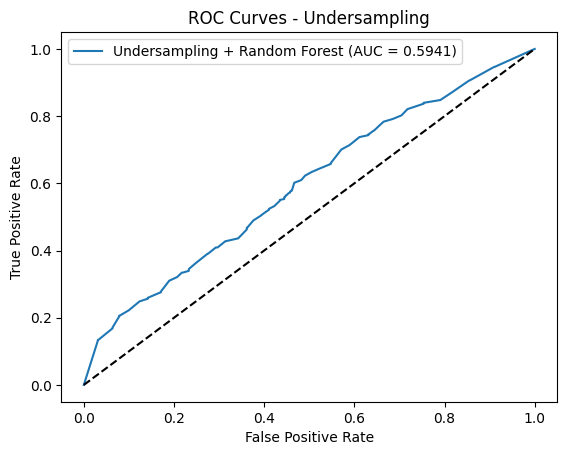

Rebalanced Model Performance Summary:
        Rebalancer                Model  Accuracy  Precision    Recall  \
0           SMOTE  K-Nearest Neighbors  0.599716   0.333916  0.510695   
1           SMOTE          Naive Bayes  0.471966   0.311224  0.815508   
2           SMOTE        Decision Tree  0.572037   0.302926  0.470588   
3           SMOTE        Random Forest  0.575586   0.310169  0.489305   
4    Oversampling  K-Nearest Neighbors  0.599006   0.329768  0.494652   
5    Oversampling          Naive Bayes  0.472676   0.311542  0.815508   
6    Oversampling        Decision Tree  0.644429   0.336761  0.350267   
7    Oversampling        Random Forest  0.643009   0.338346  0.360963   
8   Undersampling  K-Nearest Neighbors  0.568488   0.320000  0.556150   
9   Undersampling          Naive Bayes  0.471966   0.311224  0.815508   
10  Undersampling        Decision Tree  0.552874   0.308955  0.553476   
11  Undersampling        Random Forest  0.554294   0.312130  0.564171   

    F1-Scor

In [47]:
for rb_name , (X_res, y_res) in resampled_data.items():
    plt.figure(figsize=(12, 8))
    for model_name ,tuned_model in tuned_models.items():
        start_time = time.time()
        tuned_model.fit(X_res, y_res)
        train_time = time.time() - start_time
        y_pred = tuned_model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label='Yes')
        rec = recall_score(y_test, y_pred, pos_label='Yes')
        f1 = f1_score(y_test, y_pred, pos_label='Yes')

        cm = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
        plt.title(f'{rb_name} - {model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        if hasattr(tuned_model, 'predict_proba'):
            y_prob = tuned_model.predict_proba(X_test)[:, 1] if model_name != 'Naive Bayes' else tuned_model.predict_proba(X_test)[:, list(tuned_model.classes_).index('Yes')]
            y_test_bin = (y_test == 'Yes').astype(int)
            fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
            auc = roc_auc_score(y_test_bin, y_prob)
            plt.plot(fpr, tpr, label=f'{rb_name} + {model_name} (AUC = {auc:.4f})')
        else:
            auc = np.nan
        
        rebalanced_results = pd.concat([rebalanced_results, pd.DataFrame({'Rebalancer': [rb_name], 'Model': [model_name], 'Accuracy': [acc], 'Precision': [prec], 'Recall': [rec], 'F1-Score': [f1], 'AUC': [auc]})], ignore_index=True)
        
        print(f"{rb_name} + {model_name}: Accuracy = {acc:.4f}, Training Time = {train_time:.4f}s")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {rb_name}')
    plt.legend()
    plt.show()

print("Rebalanced Model Performance Summary:\n", rebalanced_results)
rebalanced_results.to_csv('rebalanced_results.csv', index=False)

***10. Comparaison Finale***


Overall Comparison Table:
             Stage                Model  Accuracy  Precision    Recall  \
0        Baseline  K-Nearest Neighbors  0.732434   0.492754  0.272727   
1        Baseline          Naive Bayes  0.734564   0.000000  0.000000   
2        Baseline        Decision Tree  0.643009   0.330709  0.336898   
3        Baseline        Random Forest  0.646558   0.339378  0.350267   
4           Tuned  K-Nearest Neighbors  0.698368   0.407273  0.299465   
5           Tuned          Naive Bayes  0.734564   0.000000  0.000000   
6           Tuned        Decision Tree  0.643009   0.330709  0.336898   
7           Tuned        Random Forest  0.648687   0.342857  0.352941   
8           SMOTE  K-Nearest Neighbors  0.599716   0.333916  0.510695   
9           SMOTE          Naive Bayes  0.471966   0.311224  0.815508   
10          SMOTE        Decision Tree  0.572037   0.302926  0.470588   
11          SMOTE        Random Forest  0.575586   0.310169  0.489305   
12   Oversampling  K-Ne

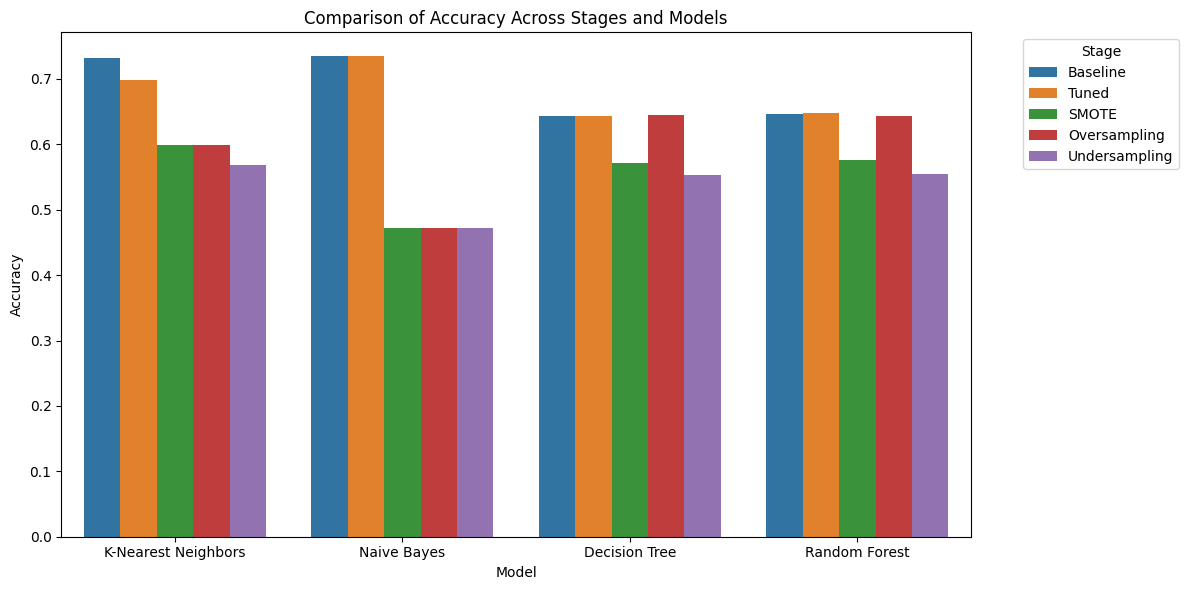

<Figure size 640x480 with 0 Axes>

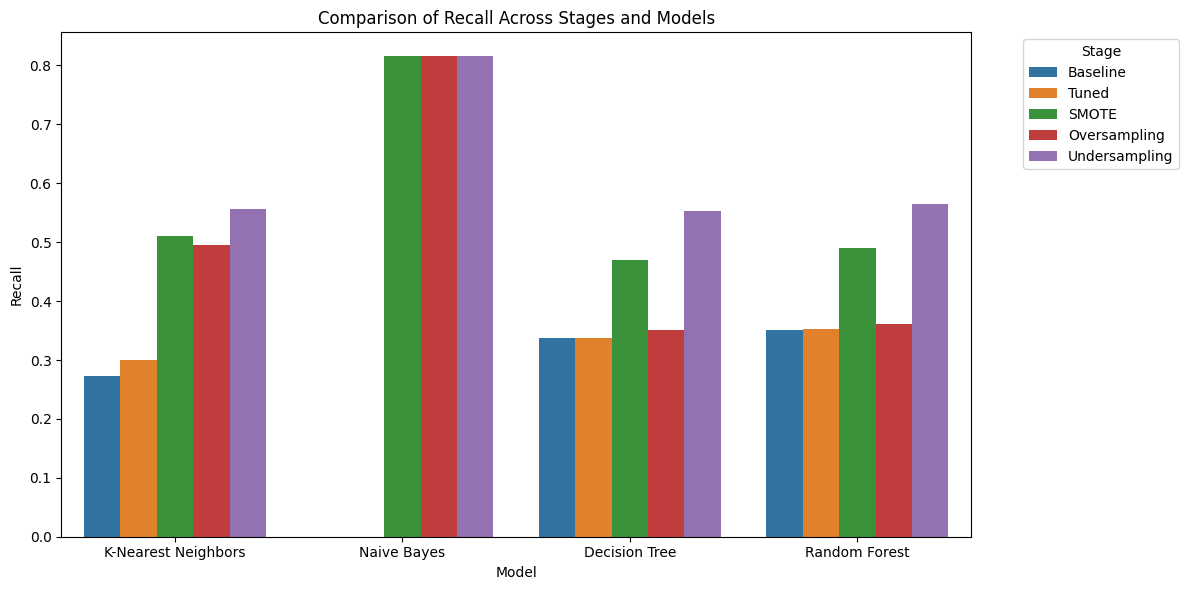

<Figure size 640x480 with 0 Axes>

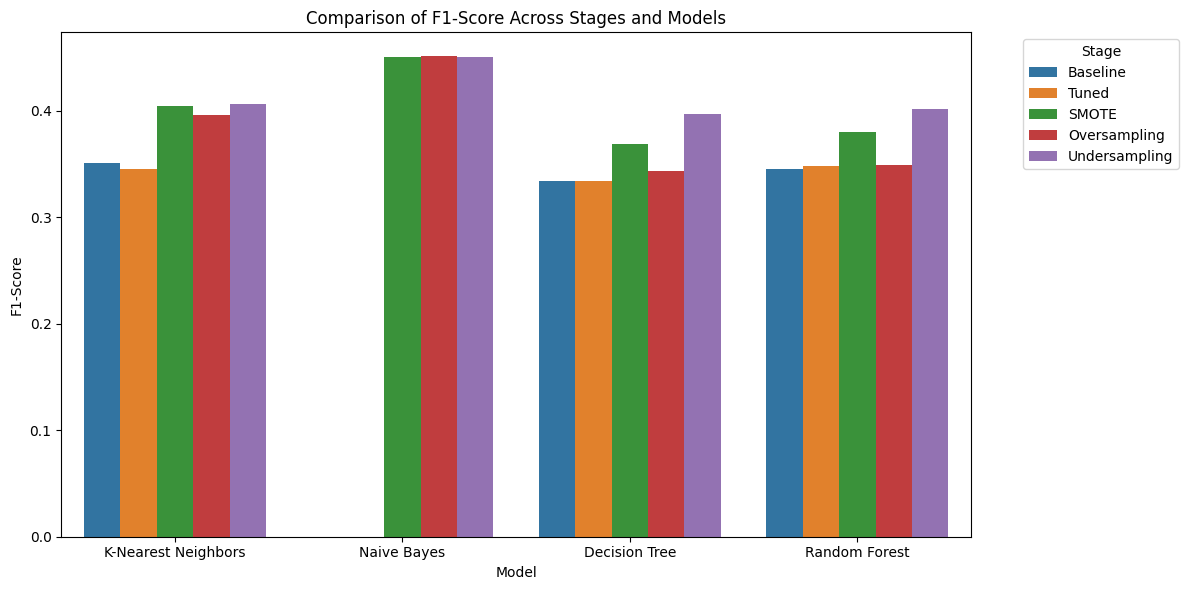

<Figure size 640x480 with 0 Axes>

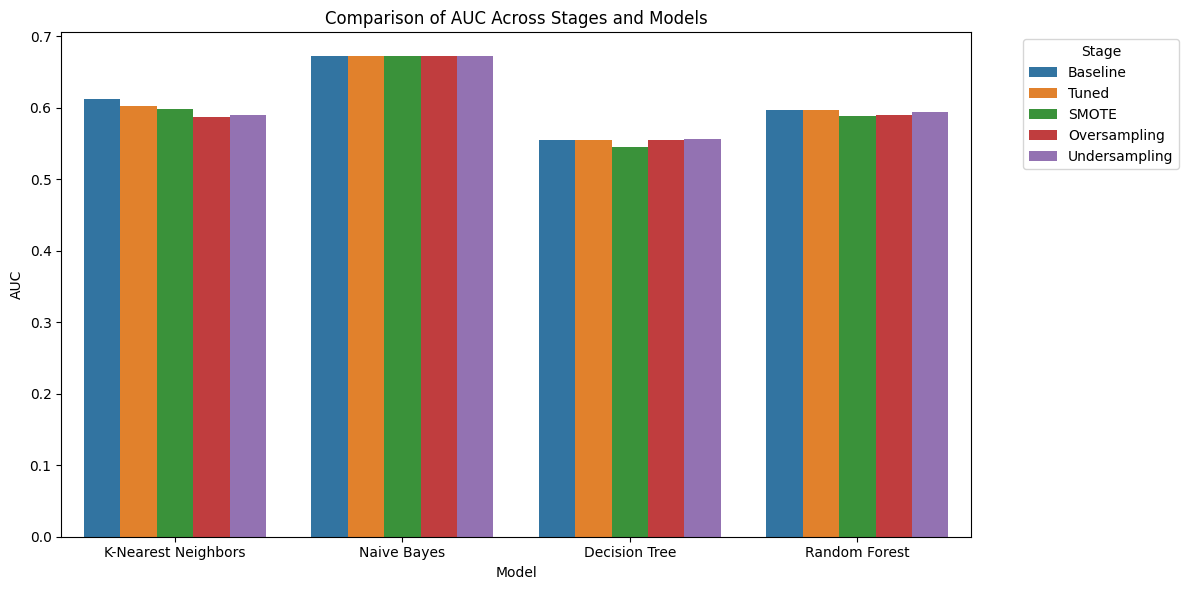

<Figure size 640x480 with 0 Axes>

In [49]:
baseline = results.copy()
baseline['Stage'] = 'Baseline'
tuned = tuned_results.copy()
tuned['Stage'] = 'Tuned'
rebalanced = rebalanced_results.copy()
rebalanced['Stage'] = rebalanced['Rebalancer']  # Use rebalancer as sub-stage
rebalanced.drop('Rebalancer', axis=1, inplace=True)  # Avoid duplication

# Combine all
all_results = pd.concat([baseline, tuned, rebalanced], ignore_index=True)

# Reorder columns for clarity
all_results = all_results[['Stage', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']]

# Display and save master table
print("\nOverall Comparison Table:\n", all_results)
all_results.to_csv('overall_results.csv', index=False)

# Graphical Visualizations: Bar plots for key metrics by stage and model
metrics_to_plot = ['Accuracy', 'Recall', 'F1-Score', 'AUC']  # Focus on these for churn (recall/F1 important)

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y=metric, hue='Stage', data=all_results)
    plt.title(f'Comparison of {metric} Across Stages and Models')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{metric}_comparison.png')